# Plot zarr archive

In [29]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import matplotlib.pyplot as plt
import anemoi.datasets as ad
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import numpy as np
import matplotlib.animation as animation

### Using anemoi-datasets to open and look at the data

In [31]:
zda = ad.open_dataset('/lustre/storeB/project/fou/hi/foccus/datasets/prepro_norkyst_tests/norkyst800_his_zdepth_2024_m00_AN_ml.zarr')
#zda = ad.open_dataset('/lustre/storeB/project/fou/hi/foccus/datasets/prepro_norkyst_tests/norkyst800_his_zdepth_2024_temp_m00_AN_ml.zarr')

In [32]:
#data_dir = "/lustre/storeB/project/fou/hi/oper/norkyst_v3/forecast/his_zdepths/2024/01/01" #param=['temperature', 'salinity', 'u_eastward', 'v_northward']
#nda = ad.open_dataset(data_dir + '/norkyst800_his_zdepth_20240101T00Z_m00_AN.nc')

In [66]:
from plot_funcs import subset_dataset, update_anim, simple_mesh_plot

In [34]:
var_name = 'temperature_1'

# Get the subsetted dataset (Northern Norway here)
lon_min, lon_max = 11.83083, 15.59072
lat_min, lat_max = 67.41791, 69.20699
var, lat, lon = subset_dataset(zda, lon_min, lon_max, lat_min, lat_max, ntime=12,var_name=var_name)

In [35]:
import sys 
sys.path.append("/lustre/storeB/project/fou/hi/foccus/ina/ocean-ai/inference")
from utils import mesh, interpolate

In [61]:
resolution=0.01 # TODO try smaller than 0.25, this is same as MEPS I think?
lat_grid, lon_grid = mesh(lat, lon, resolution)
# TODO: no need to call mesh here an also inside interpolate...

ntime = var.shape[0]
var_interp = np.empty([ntime,lat_grid.shape[0],lat_grid.shape[1]])
for itime in range(ntime):
    var_interp[itime] = interpolate(var[itime], lat, lon, resolution)

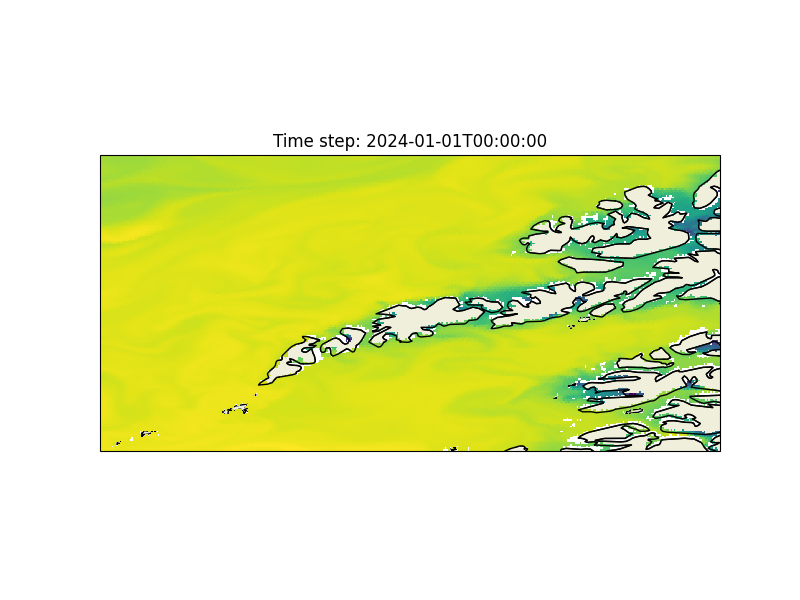

In [69]:
time_steps = zda.dates
fig, ax1, heatmap = simple_mesh_plot(lon_grid, lat_grid, var_interp[0], time_steps[0])

ani = animation.FuncAnimation(fig, update_anim, frames=ntime, interval=200,fargs=(ax1, heatmap, var_interp, time_steps))


In [ ]:
#import matplotlib.animation as animation
#ani = animation.FuncAnimation(fig, update, frames=len(time), interval=200)


(2, 1)


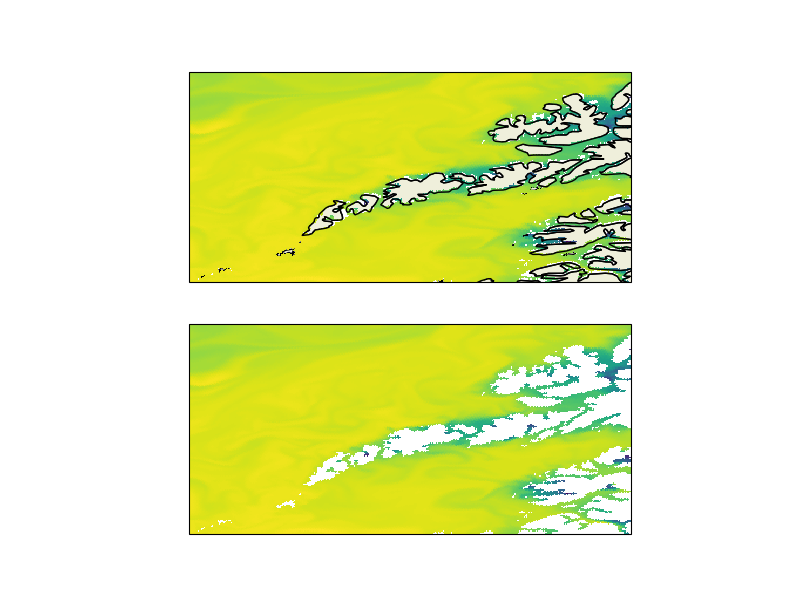

In [62]:
fig, axs = plt.subplots(2, figsize=(8,6), squeeze=False, subplot_kw={'projection': ccrs.PlateCarree()})
ax1=axs[0,0]
kwargs = {}
kwargs['shading'] = 'auto' #kwargs['vmin'] = vmin; kwargs['vmax'] = vmax #se også på norm
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, edgecolor='black')
ax1.pcolormesh(lon_grid, lat_grid, var_interp[0], **kwargs)
#ax1.contourf(lon_grid, lat_grid, data)
ax2=axs[1,0]
ax2.pcolormesh(lon_grid, lat_grid, var_interp[1], **kwargs)

#TODO: get land seamask and plot that as coastline

In [ ]:
data_crs = ccrs.PlateCarree()

proj = ccrs.LambertConformal(
        central_longitude=30, 
        central_latitude=67.9
        )
fig = plt.figure(figsize=(16,16))
ax = plt.axes(projection=proj)
ax.coastlines()

#c = ax.scatter(lon, lat, c=var[0], transform=data_crs, edgecolor=None, vmax=var.max(), vmin=var.min())
heatmap = ax.pcolormesh(lon, lat, var[0], shading='auto', cmap='viridis')

#cax,kw = mpl.colorbar.make_axes(ax, location='right', pad=0.05, shrink=0.7)
#plt.colorbar(c, cax=cax, extend='both', extendrect=False, label=(f'{var_name} (Norkyst v3)'), **kw)

plt.show()

### Exploring the dataset using anemoi-datasets

In [ ]:
dates_all = zda.dates
type(dates_all)
time_diffs = np.diff(dates_all)
#print(time_diffs,len(dates_all))

# Check if all differences are the same
consistent_intervals = np.all(time_diffs == time_diffs[0])

print("All time intervals are consistent (have the same distance in time):", consistent_intervals)

In [ ]:
zda.shape

In [ ]:
zda.variables

In [ ]:
# Data shap'en
# (24, 16, 1, 3153556) 
# tilsvarer i dette tilfellet: 24 tidssteg, 16 variables, 1 ensemble, ~3M gridpoints
zda.shape # samme som zda.data.shape

In [ ]:
# Print the methods of the dataset
dir(zda)

In [ ]:
zda.variables_metadata['temperature_1']
#zda.variables_metadata['zeta']

In [ ]:
# name_to_index will print all the variable names (16 of them) 
# and their indexes so we know how to access a variable by index
zda.name_to_index

In [15]:
# Get surface temp at time 0 by index 
# (time index, temperature_0, : , :)
surface_temp = zda[0,17,:,:]

In [ ]:
surface_temp.shape

In [ ]:
zda.dataset_metadata()['start_date']

In [ ]:
zda.dataset_metadata()['end_date']


## Matplotlib static plots below
### Plotting zarr to see if data makes sense

In [6]:
# The data are defined in lat/lon coordinate system, so PlateCarree()
# is the appropriate choice:
data_crs = ccrs.PlateCarree()

proj = ccrs.LambertConformal(
        central_longitude=30, 
        central_latitude=67.9
        )

In [ ]:
fig = plt.figure()#figsize=(20,20))
ax = plt.axes(projection=proj)
ax.coastlines()

#indx_stemp = zda.name_to_index['temperature_1']
indx_stemp = zda.name_to_index['zeta']
stemp = zda[0][indx_stemp,0,:]
# ...but now using the transform argument
c = ax.scatter(zda.longitudes, zda.latitudes, c=stemp, transform=data_crs, edgecolor=None, vmax=10, vmin=-2)
#ax.set_extent(extent,
            #crs=ccrs.PlateCarree()
#            ) 
#ax.gridlines(ls = '--', draw_labels=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

mpl.pyplot.subplots_adjust(
    left=None, 
    bottom=None, 
    right=0.75, 
    top=0.8, 
    wspace=0.1, 
    hspace=0.3
    )

#cb = plt.colorbar(c, shrink=0.5)

cax,kw = mpl.colorbar.make_axes(
        ax,
        location='right', 
        pad=0.05, 
        shrink=0.7
        )
out=plt.colorbar(
        c, 
        cax=cax, 
        extend='both', 
        extendrect=False,
        label=('Surface temp [C] (Norkyst v3)'),
        **kw
        )

### Plot more layers? and anim maybe

In [20]:

def plot_dataset(zda, var_name, indx_time=0): #, cmin=10, cmax=-2):
    # The data are defined in lat/lon coordinate system, so PlateCarree()
    # is the appropriate choice:
    """zda is a zarr file opened with anemoi datasets..."""
    data_crs = ccrs.PlateCarree()

    proj = ccrs.LambertConformal(
            central_longitude=30, 
            central_latitude=67.9
            )

    # Set up projection and plot
    fig = plt.figure(figsize=(20,20))
    ax = plt.axes(projection=proj)
    ax.coastlines()

    # Get the index of the variable and the variable itself
    indx_var = zda.name_to_index[var_name]
    var = zda[indx_time][indx_var,0,:] # we set ensemble=0 and take all grid points (last dimension)
    var_min = zda.statistics['minimum'][indx_var] 
    var_max = zda.statistics['maximum'][indx_var]

    # Scatter plot
    c = ax.scatter(zda.longitudes, zda.latitudes, var, c=var, transform=data_crs, edgecolor=None, vmax=var_max, vmin=var_min)

    # Set up gridlines
    gl = ax.gridlines(data_crs, draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    # Adjust subplot params
    plt.subplots_adjust(left=None, bottom=None, right=0.75, top=0.8, wspace=0.1, hspace=0.3)

    # Create colorbar
    cax,kw = mpl.colorbar.make_axes(ax, location='right', pad=0.05, shrink=0.7)
    plt.colorbar(c, cax=cax, extend='both', extendrect=False, label=(f'{var_name} (Norkyst v3)'), **kw)

    # Show the plot
    plt.show()

    return fig

In [21]:
temp_3000 = zda[0,12,0,:]
temp_1000 = zda[0,3,0,:]
temp_1 = zda[0,0,0,:]

In [ ]:

plot_dataset(zda, 'temperature_100')